# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:

%load_ext autoreload
%autoreload 2


import torch
from sys import platform
from utilities import *
from IPython.display import display

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier




## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Mon Feb 26 23:20:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8               1W /  55W |     12MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [40]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "local-bert"
BERT_HIDDEN_DIM = 768


DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Plotting Word Cloud 

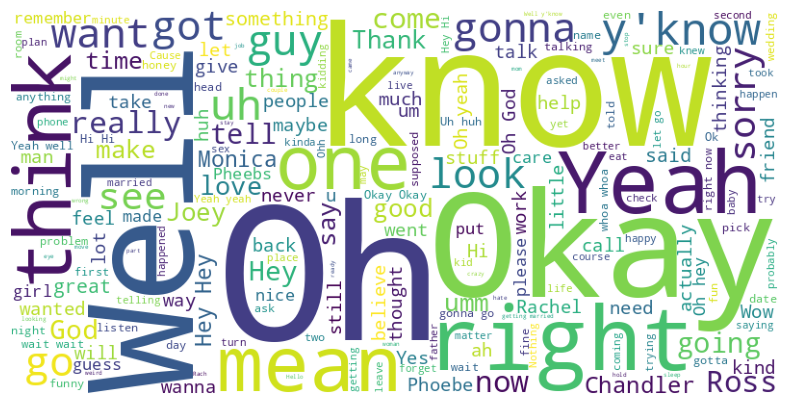

In [6]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [7]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [8]:
display_dialogue(dataframe=df, utterance_id='utterance_6')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')

### Removing NaN Values

Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


In [9]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

In [10]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


In [11]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 

In the following cell, individual utterances constituting a dialogue are concatenated to form a single string while preserving separation through the addition of the token '[SEP]'.

In [12]:
df['processed_utterances'] = df['utterances'].apply(concat_with_sep)

print("Example of concatenated utterances: ")
df['processed_utterances'].iloc[0]


Example of concatenated utterances: 


"also I was the point person on my company's transition from the KL-5 to GR-6 system. [SEP] You must've had your hands full. [SEP] That I did. That I did. [SEP] So let's talk a little bit about your duties. [SEP] My duties?  All right."

### Splitting the dataset 

In [13]:
train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df.head())

print("\nValidation Set: ")
display(val_df.head())

print("\nTest Set: ")
display(test_df.head())


Training Set: 


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_3057,"[Joey, Phoebe, Chandler, Phoebe, Chandler, Pho...","[joy, neutral, neutral, surprise, neutral, neu...","[I found my identical hand twin!, Ohh, you are...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","I found my identical hand twin! [SEP] Ohh, you..."
utterance_2854,"[Monica, Rachel, Phoebe, Phoebe, Phoebe, Rache...","[anger, joy, anger, anger, anger, anger, neutral]","[Did you just flick me?, OK, well, you wouldn'...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]","Did you just flick me? [SEP] OK, well, you wou..."
utterance_332,"[Rachel, Joanna, Rachel]","[neutral, neutral, fear]","[My drinking?, Oh, I must've said that after y...","[0.0, 1.0, 0.0]","My drinking? [SEP] Oh, I must've said that aft..."
utterance_421,"[Phoebe, Monica, Chandler, Chandler, Phoebe, C...","[neutral, joy, joy, disgust, anger, neutral]","[Well, look, why don't you just, why don't you...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","Well, look, why don't you just, why don't you ..."
utterance_3901,"[Ross, Ross, Ross, Ross, Carol, Ross, Carol, P...","[anger, anger, anger, anger, joy, surprise, ne...","[....right?, Right?, I mean it's pretty unbeli...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",....right? [SEP] Right? [SEP] I mean it's pret...



Validation Set: 


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_274,"[Chandler, Ticket Counter Attendant, Chandler,...","[neutral, surprise, neutral, surprise, neutral...","[Okay. Then I guess it's just, wait here then....","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]","Okay. Then I guess it's just, wait here then. ..."
utterance_1373,"[Ross, Rachel, Ross, Rachel, Ross, Chandler, R...","[neutral, neutral, neutral, surprise, neutral,...","[Okay, I've got three of my five., Three of yo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","Okay, I've got three of my five. [SEP] Three o..."
utterance_2712,"[Guy #1, Joey, Woman, Joey, Woman, Joey, Woman]","[joy, neutral, joy, neutral, neutral, neutral,...","[Nice car!, Yeah, it's not mine., I love your ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","Nice car! [SEP] Yeah, it's not mine. [SEP] I l..."
utterance_2906,"[Rick, Phoebe, Rick, Phoebe]","[surprise, sadness, anger, neutral]","[Wow, you have really pretty feet., These old ...","[0.0, 0.0, 1.0, 1.0]","Wow, you have really pretty feet. [SEP] These ..."
utterance_3991,"[Joey, Stanley, Joey, Stanley, Joey, Stanley, ...","[joy, sadness, surprise, sadness, surprise, ne...",[Hey-hey! Stanley! Hey-hey! You're leading man...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Hey-hey! Stanley! Hey-hey! You're leading man ...



Test Set: 


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_3705,"[Monica, Rachel, Chip, Rachel]","[fear, neutral, joy, joy]",[Not yet! Not yet! Not yet! Not yet! Not yet! ...,"[0.0, 0.0, 0.0, 1.0]",Not yet! Not yet! Not yet! Not yet! Not yet! N...
utterance_760,"[Monica, Mischa, Monica, Phoebe, Phoebe, Phoeb...","[joy, neutral, surprise, neutral, neutral, neu...","[Oh, and I can also speak a little French. Vou...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Oh, and I can also speak a little French. Voul..."
utterance_30,"[Chandler, Joey, Chandler, Joey, Chandler, Joe...","[joy, surprise, joy, neutral, neutral, anger, ...","[Good job Joe! Well done! Top notch!, You like...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]",Good job Joe! Well done! Top notch! [SEP] You ...
utterance_3595,"[Phoebe, Rachel, Phoebe, Rachel, Phoebe, Rache...","[anger, neutral, neutral, fear, surprise, joy,...","[Hey!, Hi., Are you all right?, Uhh… I think I...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Hey! [SEP] Hi. [SEP] Are you all right? [SEP] ...
utterance_3404,"[Phoebe, Phoebe, Phoebe, Phoebe, Phoebe, Phoeb...","[neutral, neutral, neutral, neutral, joy, neut...","[Me too., Although this city is my home, so., ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","Me too. [SEP] Although this city is my home, s..."


### Visualizing the distribution of the emotions over the datasets

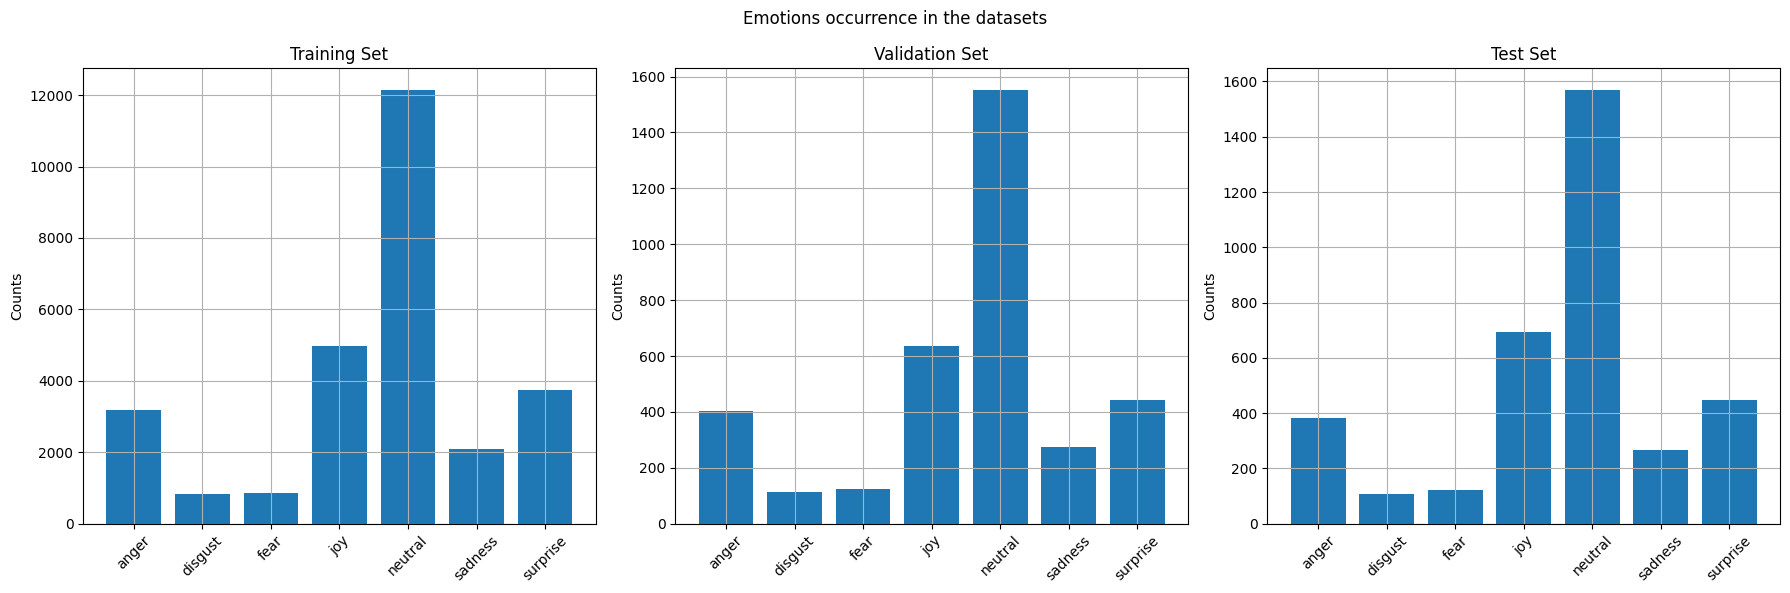

In [14]:
plot_emotion_distribution(train_df, val_df, test_df)


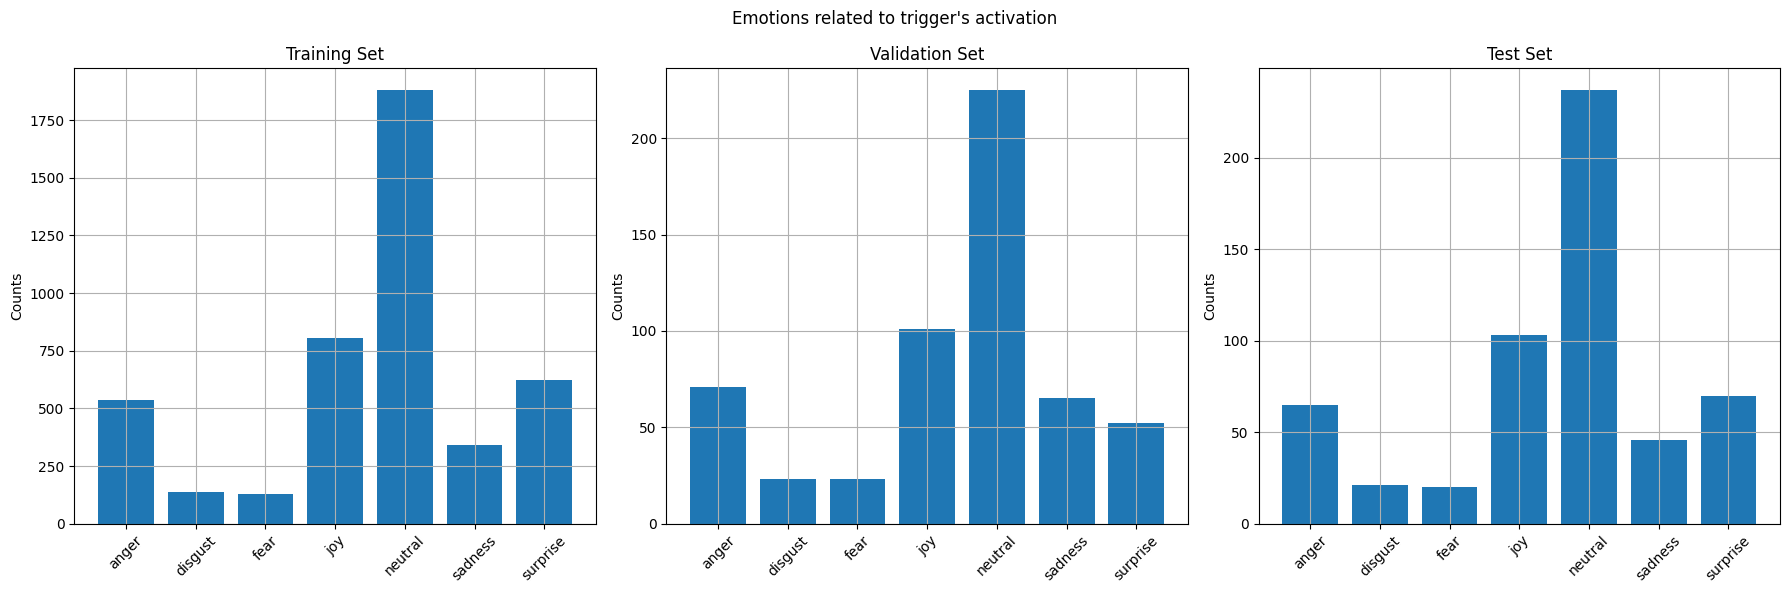

In [15]:
# How many times each emotion activates a trigger
plot_triggers_per_emotion(train_df, val_df, test_df)

### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [16]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
trigger_weights = create_classes_weights(df['triggers'].sum())

print('Emotion weights')
display(pd.DataFrame({'Emotion': EMOTIONS, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': [0, 1], 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426


Trigger weights


,Trigger,Weight
0,0,0.594761
1,1,3.138206


## Random Classifier

In [17]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,fear,Not yet! Not yet! Not yet! Not yet! Not yet! N...,0.0,joy,0
1,Rachel,neutral,"Hello, Chip.",0.0,disgust,0
2,Chip,joy,"Hey, Rach! How ya doin'?",0.0,surprise,1
3,Rachel,joy,I'm great! I'm great. I've got a great job at,1.0,fear,1


## Majority Classifier

In [18]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,fear,Not yet! Not yet! Not yet! Not yet! Not yet! N...,0.0,neutral,0.0
1,Rachel,neutral,"Hello, Chip.",0.0,neutral,0.0
2,Chip,joy,"Hey, Rach! How ya doin'?",0.0,neutral,0.0
3,Rachel,joy,I'm great! I'm great. I've got a great job at,1.0,neutral,0.0


## Bert Models

In [19]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


In [37]:
from DrTorch.utilities import DataLoaderFromPipelineStrategy
 
dataLoaderBuilder = DataLoaderFromPipelineStrategy()
dataloader = dataLoaderBuilder.create(train_df["utterances"].copy(), 
                                      train_df[["emotions", "triggers"]].copy(), 
                                      shuffle=True,
                                      data_preprocess_f=tokenize_data, 
                                      labels_preprocess_f=preprocess_labels,
                                      batch_size=1,
                                      device=device)

n_token_per_utterance = next(iter(dataloader))[0]['input_ids'].shape[-1] 



In [41]:
for data, label in dataloader:
    print("Shape should be: [batch_size, n_frasi,*n_token]")
    print("Shape dei dati: ", data['input_ids'].shape)
    print("Shape delle emotions: ", label["emotions"].shape)
    print("Shape delle triggers: ", label["triggers"].shape)
    break


n_features = n_token_per_utterance * BERT_HIDDEN_DIM


Shape should be: [batch_size, n_frasi,*n_token]
Shape dei dati:  torch.Size([1, 24, 95])
Shape delle emotions:  torch.Size([1, 24, 8])
Shape delle triggers:  torch.Size([1, 24, 3])


In [42]:
from models.bertFreezed import * 
bertest= BertFreezed(bert_model=bert_model, cls_input_size=n_features, n_emotions=8)

for data, label in dataloader:
    pred = bertest(data)
    print(pred)
    break



torch.Size([1, 24, 72960])
torch.Size([1, 24, 8])
torch.Size([1, 24, 3])
{'emotions': tensor([[[0.0380, 0.0358, 0.0402, 0.0435, 0.0362, 0.0264, 0.0628, 0.0443],
         [0.0469, 0.0644, 0.0440, 0.0424, 0.0349, 0.0361, 0.0585, 0.0505],
         [0.0492, 0.0614, 0.0356, 0.0470, 0.0349, 0.0347, 0.0563, 0.0476],
         [0.0521, 0.0499, 0.0398, 0.0512, 0.0429, 0.0316, 0.0507, 0.0468],
         [0.0464, 0.0435, 0.0316, 0.0497, 0.0509, 0.0285, 0.0462, 0.0740],
         [0.0595, 0.0599, 0.0362, 0.0405, 0.0570, 0.0403, 0.0569, 0.0682],
         [0.0545, 0.0403, 0.0285, 0.0527, 0.0435, 0.0385, 0.0614, 0.0624],
         [0.0476, 0.0458, 0.0249, 0.0471, 0.0514, 0.0509, 0.0615, 0.0786],
         [0.0384, 0.0380, 0.0461, 0.0386, 0.0389, 0.0441, 0.0339, 0.0339],
         [0.0381, 0.0361, 0.0432, 0.0409, 0.0415, 0.0459, 0.0339, 0.0324],
         [0.0375, 0.0389, 0.0465, 0.0381, 0.0399, 0.0439, 0.0341, 0.0339],
         [0.0375, 0.0367, 0.0441, 0.0389, 0.0417, 0.0442, 0.0344, 0.0317],
         [0.03

In [ ]:
import pandas as pd

# Esempio di DataFrame con una colonna di dialoghi
data1 = {'lista_di_stringhe': [["ciao come stai", "io bene", "ottimo cazzo"], 
                              ["Maremma maiala", "le phoppe la smerda"],
                              ["hello how are you", "Everything's fine", "La fessa di tu ma", "Grazie altrettanto"]]}
data2 = {'lista_di_stringhe': [["ciao"],
                              ["hello how are you", "Everything's fine", "La fessa di tu ma", "Grazie altrettanto"]]}
df_test = pd.DataFrame(data1)

def process_utterances(data):
    data = data.apply(lambda x: " [SEP] ".join(x) + " [SEP]")
    
    max_num_sentences = max(data.apply(lambda x: x.count('[SEP]')))
    
    for index, row in data.items():  
        num_sentences = row.count('[SEP]')
        num_pads_needed = max_num_sentences - num_sentences - 1
        if num_pads_needed >= 0:
            pads = '[PAD]'
            data.at[index] += ' ' + ' [SEP] '.join([pads] * (num_pads_needed + 1)) + ' [SEP] '
    
    return data

df_test['lista_di_stringhe'] = process_utterances(df_test['lista_di_stringhe'])
df_test

In [ ]:
def find_max_encoded_utterance(tokenizer, data) -> int:
    utterances = data.sum()
    
    tokenized_batch = tokenizer.batch_encode_plus(utterances,
                                                  padding=True,
                                                  return_tensors='pt'
    )
    
    return tokenized_batch["input_ids"].shape[1]

def tokenize_data(data):
    tokenizer = BertTokenizer.from_pretrained("local-bert") 
    
    max_token_length = find_max_encoded_utterance(tokenizer, data)
    
    # Inizializzazione delle liste per salvare i risultati tokenizzati
    tokenized_texts = []
    attention_masks = []
    token_type_ids_list = []

    for text_list in data:
        tokenized_batch = tokenizer.batch_encode_plus(
            text_list,
            padding="max_length",
            max_length=max_token_length,
            return_tensors='pt'
        )
        tokenized_texts.append(tokenized_batch['input_ids'])
        attention_masks.append(tokenized_batch['attention_mask'])
        token_type_ids_list.append(tokenized_batch['token_type_ids'])
    
    # Definizione della funzione di padding
    def pad_sequences(sequences, pad_token_id):
        max_list_length = max(seq.size(0) for seq in sequences)
        padded_sequences = []
        for seq in sequences:
            padding_needed = max_list_length - seq.size(0)
            if padding_needed > 0:
                padding_tensor = torch.full((padding_needed, seq.size(1)), pad_token_id)
                padded_seq = torch.cat([seq, padding_tensor], dim=0)
            else:
                padded_seq = seq
            padded_sequences.append(padded_seq)
        return torch.stack(padded_sequences)
    
    # Applica il padding alle liste
    padded_texts_tensor = pad_sequences(tokenized_texts, tokenizer.pad_token_id)
    padded_attention_masks = pad_sequences(attention_masks, 0)  # Usa 0 per padding l'attention mask
    padded_token_type_ids = pad_sequences(token_type_ids_list, 0)  # Usa 0 per padding i token type ids
    
    # Costruisci il dizionario di output
    batch_size = padded_texts_tensor.shape[0]
    output = {
        'input_ids': padded_texts_tensor.view(batch_size, -1),
        'attention_mask': padded_attention_masks.view(batch_size, -1),
        'token_type_ids': padded_token_type_ids.view(batch_size, -1)
    }
    
    return output

frasine =  df["utterances"] # 3 righe di dataframe -> df.iloc[[0,5,10], 2]
AAA = tokenize_data(frasine)
AAA["input_ids"].shape
